## 1. 导入包

In [14]:
import qdrant_client
import open_clip
from llama_index.core import (ServiceContext, 
                               SimpleDirectoryReader,
                               SimpleDirectoryReader,
                               StorageContext,
                               Settings)
from llama_index.core.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.embeddings.clip import ClipEmbedding
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

# load image documents from local directory
image_documents = SimpleDirectoryReader('E:/RAG_LLM/test/').load_data()

mm_model = OllamaMultiModal(model="llava")

In [15]:
mm_model

OllamaMultiModal(base_url='http://localhost:11434', model='llava', temperature=0.75, context_window=3900, request_timeout=None, additional_kwargs={})

In [16]:
response = mm_model.complete(prompt="what is in the image?", image_documents=image_documents)

In [17]:
response.text

' The image shows a street scene with residential buildings on both sides of the road. There are parked cars along the curb, and a red brick fence can be seen behind one of the cars. In the background, there is a clear blue sky and some trees, indicating it might be spring or summer due to the leaves on the trees. The photo appears to have been taken with a smartphone as indicated by the interface at the bottom, including a camera shutter button and a social media application icon. There are no people visible in this particular shot. '

In [18]:
import matplotlib.pyplot as plt
import os
import io 
from PIL import Image 
import json

# Define a function to plot images given a list of image paths
def plot_images(image_paths):
    # Initialize a counter to track the number of images shown
    images_shown = 0
    # Set the figure size for the entire plot
    plt.figure(figsize=(16, 9))
    # Iterate through each image path in the provided list
    for img_path in image_paths:
        # Check if the file exists
        if os.path.isfile(img_path):
            # Open the image using the Image module
            image = Image.open(img_path)
            # Create a subplot for the current image in a 2x3 grid
            plt.subplot(2, 3, images_shown + 1)
            # Display the image in the subplot
            plt.imshow(image)
            # Remove x and y ticks for clarity
            plt.xticks([])
            plt.yticks([])
            # Increment the counter for images shown
            images_shown += 1
            # Break the loop if 9 images have been shown
            if images_shown >= 9:
                break

In [19]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="E:/RAG_LLM/dataset/placepulse_test2")

# if you only need image_store for image retrieval,
# you can remove text_sotre
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

In [20]:
## Load it(注意，同一个数据库，不能embed两次，不然会重复)
# Load text and image documents from local folder
documents = SimpleDirectoryReader("E:/RAG_LLM/test_img/").load_data()
# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    show_progress=True
)
# Save it
index.storage_context.persist(persist_dir="E:/RAG_LLM/dataset/storage")

Parsing nodes:   0%|          | 0/52 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

Generating image embeddings:   0%|          | 0/51 [00:00<?, ?it/s]

In [6]:
## Load it(注意，同一个数据库，不能embed两次，不然会重复)
# # # Load it
# from llama_index.core import load_index_from_storage

# storage_context = StorageContext.from_defaults(
#     vector_store=text_store, persist_dir="E:/RAG_LLM/dataset/storage"
# )
# index = load_index_from_storage(storage_context, image_store=image_store)

In [21]:
## define retriver_engine
retriever_engine = index.as_retriever(similarity_top_k=5, image_similarity_top_k=5) ## topk

### 2. Retrive-->LLM (RAG_type 1）

RAG Type (text to image; image to image; image to text)  
1.load data and embeding  
2.construction retrieve(.as_retriever)  
3.using retriever(.retrieve(query_str))-->results  
4.LLM generation

In [22]:
import json
metadata_str = json.dumps('E:/RAG_LLM/test_img/metadata.json')
metadata_str

'"E:/RAG_LLM/test_img/metadata.json"'

In [23]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

## define retrive function
def retrieve_text(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

## define retrive function
def retrieve_img(retriever_engine, img_path):
    retrieval_results = retriever_engine.image_to_image_retrieve(img_path)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

**Node ID:** 323602fb-f3d1-41db-85a1-c7be01bf7357<br>**Similarity:** 0.7091806910886859<br>**Text:** JPG",
        "Caption": "['a street with a street sign on the side of the road and cars parked on the side of the road']",
        "livelier": "2.863879892",
        "more beautiful": "5.273389...<br>

**Node ID:** eb94c0a0-265d-4d4d-8265-cbb184185987<br>**Similarity:** 0.693495661353386<br>**Text:** 84525322",
        "wealthier": "5.310470874"
    },
    {
        "Image Name": "1.305174_103.860022_50f561cbfdc9f065f0005727_Singapore.JPG",
        "Relative Path": "./test_img\\1.305174_10...<br>

**Node ID:** 4794c52d-2835-4d2f-af66-8ffa5c41a31b<br>**Similarity:** 0.6849520956758<br>**Text:** 288977317",
        "wealthier": "5.610686075"
    },
    {
        "Image Name": "1.316395_103.875034_50f5608efdc9f065f0005200_Singapore.JPG",
        "Relative Path": "./test_img\\1.316395_1...<br>

**Node ID:** 9daa4f73-f033-4dc6-b1c5-baf738427119<br>**Similarity:** 0.6780957978032331<br>**Text:** /test_img\\1.293146_103.802320_50f561effdc9f065f0005771_Singapore.JPG",
        "Caption": "['a city bus driving down a street next to a tree lined park ian street with a bus parked on the side']"...<br>

**Node ID:** 0576cecb-92a4-4847-b957-6c429fab580a<br>**Similarity:** 0.6676163134148094<br>**Text:** "Relative Path": "./test_img\\1.310265_103.791255_50f56204fdc9f065f000589a_Singapore.JPG",
        "Caption": "['a road with trees and a fence and a street sign on the side of the road near a fenc...<br>

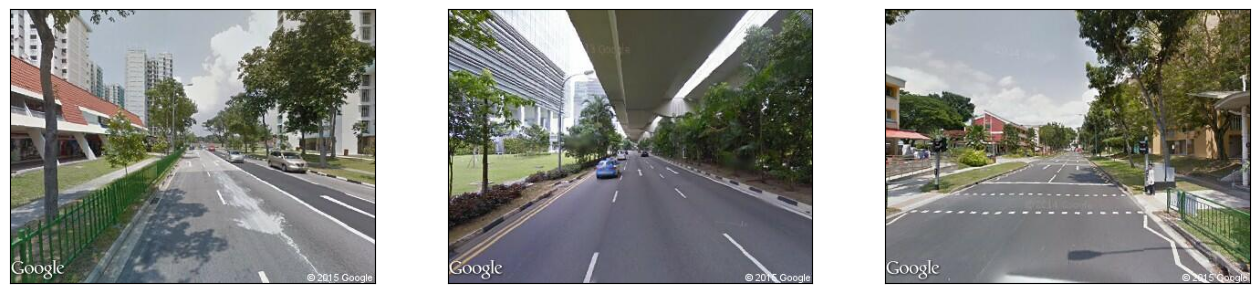

In [68]:
## conduct text retrive\

## your question
query_str = "a street with building on the side of the road"

## retrive
img, txt = retrieve_text(retriever_engine=retriever_engine, query_str=query_str)

## retrived image and reload using'SimpleDirectoryReader'
image_documents = SimpleDirectoryReader(input_dir="E:/RAG_LLM/test_img/", input_files=img).load_data()
## contextual information (上下文信息)
context_str = "".join(txt)
plot_images(img[0:3])  ## visualization

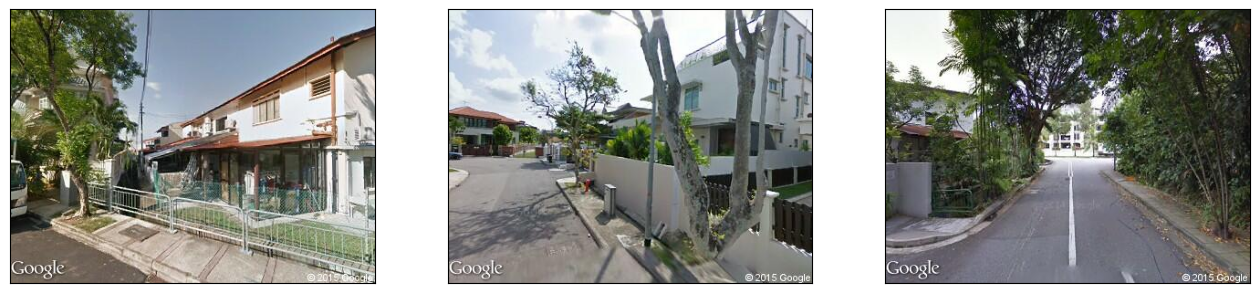

In [82]:
# ## image retrive !! without txt
# img, txt = retrieve_img(retriever_engine=retriever_engine, 
#                         img_path="20.695691_-103.362361_51413371fdc9f049260042da_Guadalajara.JPG")
# plot_images(img[0:3])

In [27]:
## LLM templet
qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the image, \
     accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"     ## 将上下文信息放进去
    "Metadata: {metadata_str} \n"  ## 将原始的meta信息放进去
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [ ]:
## based on text_retrived
## your question
# query_strs = "which one is a most lively street? give me the name and specific score!"

## use'.complete' invoke LLM
response = mm_model.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str,
        query_str=query_str, 
        metadata_str=metadata_str
    ),
    image_documents=image_documents,
)

In [ ]:
response.text

### 3. LLM-->query (RAG_type 2）

In [50]:
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine
from llama_index.multi_modal_llms.ollama import OllamaMultiModal
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core import SimpleDirectoryReader

mm_model = OllamaMultiModal(model="llava")


qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the image, \
     accurately and precisely answer the query without any additional prior knowledge.\n"
#     "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"     ## 将上下文信息放进去
#     "Metadata: {metadata_str}\n"   ## 将原始的meta信息放进去
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

## query的方式查询
query_engine = index.as_query_engine(
    llm=mm_model, 
    text_qa_template=qa_tmpl,
    similarity_top_k=3, image_similarity_top_k=3
)

In [ ]:
query_str = "give me three most beautiful streets and specific scores"
response = query_engine.query(query_str)

In [ ]:
response.response

In [ ]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)

In [ ]:
from llama_index.core import PromptTemplate

qa_tmpl_str = (
    "Given the images provided, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=mm_model, image_qa_template=qa_tmpl
)

In [ ]:
Image.open('1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG')

In [ ]:
query_str = "Tell me more about the relationship between those scense."
response = query_engine.image_query("1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG", query_str)

In [ ]:
response.response

In [ ]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["image_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)

In [ ]:
!wget "https://www.dropbox.com/scl/fi/mlaymdy1ni1ovyeykhhuk/tesla_2021_10k.htm?rlkey=qf9k4zn0ejrbm716j0gg7r802&dl=1" -O tesla_2021_10k.htm
!wget "https://docs.google.com/uc?export=download&id=1THe1qqM61lretr9N3BmINc_NWDvuthYf" -O shanghai.jpg

# from llama_index import SimpleDirectoryReader
from pathlib import Path
from llama_index.readers.file import UnstructuredReader
from llama_index.core.schema import ImageDocument


# loader = UnstructuredReader()
# documents = loader.load_data(file=Path("tesla_2021_10k.htm"))

image_doc = ImageDocument(image_path="1.274615_103.797243_50f561a0fdc9f065f0005614_Singapore.JPG")

In [1]:
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_pipeline import QueryPipeline, FnComponent

query_prompt_str = """\
Please expand the initial statement using the provided context from the Tesla 10K report.

{initial_statement}

"""
query_prompt_tmpl = PromptTemplate(query_prompt_str)

# MM model --> query prompt --> query engine
qp = QueryPipeline(
    modules={
        "mm_model": mm_model.as_query_component(
            partial={"image_documents": [image_doc]}
        ),
        "query_prompt": query_prompt_tmpl,
        "query_engine": query_engine,
    },
    verbose=True,
)
qp.add_chain(["mm_model", "query_prompt", "query_engine"])
rag_response = qp.run("Which Tesla Factory is shown in the image?")

NameError: name 'mm_model' is not defined